In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy
import os, sys
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Initial research for a Bayesian fundamental risk premia hedge fund

**Assets Traded**
-----------------
1) Equities
    - Exact breakdown is TBD
    - Categorization will either be by sector (and separated by country), or by Market Cap.
    - Or, and this may be better, by volatiltiy. This allows combining Market Cap. with Sector
    - Securities will be ETFs capturing the relecant market
2) FX
    - Categorized by developed and developing markets
3) Commodities
    - Again captured by ETFs
    - Categorization is up in the air, but potentially by hard/soft commodities
4) Fixed income
    - Natural categorization could be rating
    
**Risk Premia Used**
------------------
1) Momentum
    - Start with SMA crossover
2) Value
3) Carry

**How is this Bayseian?**
-------------------
1) At the most basic level, the idea is to infer a hierarchical regression
    - Returns ~ Indicator*a + B
    - a, B inferred from hierarchy {Asset Type} -> {Categorization} -> {Security}
2) Also interested in inferring parameters for Risk Premia calculations
    -e.g, the exact windows for the moving averages in the momentum calculation

# Step 1:
## Collect data and calculate indicators

*Initial Securities List:
Equities:
- SPY (SP500)
- EFA (Extended developed markets)
- EWJ (Japan)
- FXI (China Large-cap)
- VWO (Emerging Markets)
- IJH (SP500 Mid-cap)
- IJR (SP500 Small-cap)
- IWF (Russell 1000 Growth)
- VIG (Divided Appreciation)


Fixed Income:
- LQD (Investment Grade Corporate)
- HYG (High-yield Coroporate)
- EMB (Emerging Market Debt)
- AGG (US Debt)

Commodities:
- GLD (Gold)
- UCO (Oil)
- JO (Coffee)
- SGG (Sugar)
- PPLT (Platinum)
- VXX (Volatility)

FX:
- UUP (USD)
- FXE (EURO)
- FXB (BPS)
- FXC (CAD)
- FXA (AUD)
- FXY (JPY)
- CEW (Emerging Markets)
- BZF (BRL)

In [2]:
root_dir = os.getcwd()

In [3]:
tickers = dict(
    SPY=dict(asset='equity'),
    EWJ=dict(asset='equity'),
    FXI=dict(asset='equity'),
    EFA=dict(asset='equity'),
    VWO=dict(asset='equity'),
    IJH=dict(asset='equity'),
    IJR=dict(asset='equity'),
    IWF=dict(asset='equity'),
    VIG=dict(asset='equity'),
    LQD=dict(asset='bond'),
    HYG=dict(asset='bond'),
    EMB=dict(asset='bond'),
    AGG=dict(asset='bond'),
    GLD=dict(asset='commodity'),
    UCO=dict(asset='commodity'),
    JO=dict(asset='commodity'),
    SGG=dict(asset='commodity'),
    PPLT=dict(asset='commodity'),
#     VXX=dict(asset='commodity'),
    UUP=dict(asset='fx'),
    FXE=dict(asset='fx'),
    FXB=dict(asset='fx'),
    FXY=dict(asset='fx'),
    CEW=dict(asset='fx'),
    BZF=dict(asset='fx'),
)

In [4]:
def vol_category_helper(row, *args):
    q0, q1, q2, q3 = args
    if row <= q0:
        return 0
    elif row <= q1:
        return 1
    elif row <= q2:
        return 2
    elif row <= q3:
        return 3
    else:
        return 3

In [5]:
def beta_helper(row, *args):
    spy = args[0]
    try:
        return pd.Series(dict(beta=(row['corr'] * row['vol']) / spy.loc[row['Date'], 'vol'],
                              market_log_return=spy.loc[row['Date'], 'log_return']))
    except KeyError:
        return pd.Series(dict(beta=np.nan, market_log_return=np.nan))

In [6]:
def corr_helper(row, *args):
    correl = args[0]
    try:
        return correl['SPY'][row.Date][row.ticker]
    except KeyError:
        return np.nan

In [7]:
def calc_momentum(combined, fast_window=7, slow_window=25):
    for ticker in combined['ticker'].unique():
        combined.loc[combined['ticker'] == ticker, 'fast'] =\
        combined.loc[combined['ticker'] == ticker, 'Close'].rolling(fast_window).mean()

        combined.loc[combined['ticker'] == ticker, 'slow'] =\
        combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
        
    return pd.to_numeric((combined['fast'] - combined['slow']) / combined['slow'])

In [8]:
def build_prices_dfs(tickers, n_categories=3):
    out = dict()
    tickers = os.listdir(root_dir+'/data/equities') + os.listdir(root_dir+'/data')
    for ticker in tickers:
        if '.csv' in ticker:
            try:
                df = pd.read_csv(root_dir+'/data/equities/{}'.format(ticker))
            except FileNotFoundError:
                df = pd.read_csv(root_dir+'/data/{}'.format(ticker))
            df = df.replace({'null': np.nan})
            df['Close'] = pd.to_numeric(df['Close'])
            df['ticker'] = ticker[:-4]
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date', False)
            df['pct_change'] = pd.to_numeric(df['Close'].pct_change().shift(-1))
            df['log_return'] = (np.log(df.Close) - np.log(df.Close.shift(1))).shift(-1)

            # Calculate vol on a 1 year rolling basis
            df['vol'] = df['pct_change'].rolling(252).std()
            df['month_return'] = pd.to_numeric(pd.rolling_sum(df['pct_change'][::-1], window=22, min_periods=22)[::-1])
            df['month_log_return'] = pd.to_numeric(pd.rolling_sum(df['log_return'][::-1], window=22, min_periods=22)[::-1])
            out[ticker] = df
    combined = pd.concat([_df for _df in out.values()])
    
    gb_equity = pd.DataFrame()
    for key, grp in combined.groupby('ticker'):
        gb_equity[key] = grp['log_return']
    correl = gb_equity.rolling(252).corr()
    combined['corr'] = combined.apply(corr_helper, axis=1, args=(correl, ))
    combined['beta'] = 0
    combined['market_log_return'] = 0
    combined.loc[:, ['beta', 'market_log_return']] = combined.apply(beta_helper, axis=1,
                                                             args=(combined.loc[combined.ticker == 'SPY'], ))
    combined['alpha'] = combined['log_return'] - (combined['market_log_return'] * combined['beta'])
    combined['market_log_return_shift'] = combined['market_log_return'].shift(1)
    combined['beta_abs'] = combined['beta'].abs()
    combined['ra_return'] = combined['month_log_return'] / combined['beta_abs']
    for key, grp in combined.groupby('ticker'):
        combined.loc[combined['ticker'] == key, 'ra_month_return'] = pd.rolling_sum(grp['ra_return'][::-1], window=22,
                                                                                    min_periods=22)[::-1]
    q0, q1, q2, q3 = combined['vol'].quantile([.2, .4, .6, .8])
    # Equities are placed into 4 vol categories based on their moment-in-time volatility relative to all historical
    # observed vols
    combined['category'] = combined['vol'].apply(vol_category_helper, args=(q0, q1, q2, q3))
    combined['momentum'] = calc_momentum(combined)
    return out, combined
        

In [2]:
try:
    combined = pd.read_pickle('combined.pkl')
except:
    prices, combined = build_prices_dfs()
    pd.to_pickle(combined, 'combined.pkl')

In [14]:
combined['market_log_return_shift'] = combined['market_log_return'].shift(1)

In [17]:
combined['beta_times_spy'] = combined['beta'] * combined['market_log_return_shift']

In [98]:
combined.loc[combined['ticker']!='SPY', ['value', 'vol', 'category', 'momentum', 'month_log_return', 'alpha', 'beta', 'beta_abs']].corr()

,value,vol,category,momentum,month_log_return,alpha,beta,beta_abs
value,1.000000,-0.150157,-0.056443,0.262367,0.020320,0.000013,0.251411,-0.018817
vol,-0.150157,1.000000,0.900179,-0.002021,-0.000932,0.000601,0.285303,0.551145
category,-0.056443,0.900179,1.000000,-0.007159,-0.005499,-0.001768,0.320332,0.548058
momentum,0.262367,-0.002021,-0.007159,1.000000,0.019365,-0.001488,0.064156,-0.022722
month_log_return,0.020320,-0.000932,-0.005499,0.019365,1.000000,0.183831,0.067710,-0.026541
alpha,0.000013,0.000601,-0.001768,-0.001488,0.183831,1.000000,0.005721,-0.005055
beta,0.251411,0.285303,0.320332,0.064156,0.067710,0.005721,1.000000,0.267670
beta_abs,-0.018817,0.551145,0.548058,-0.022722,-0.026541,-0.005055,0.267670,1.000000


In [97]:
combined['category'] = pd.to_numeric(combined['category'])

In [121]:
def vol_category_helper(row):
    if row <= q1:
        return 1
    elif row <= q2:
        return 2
    elif row <= q3:
        return 3
    else:
        return 4

In [122]:
combined['category'] = combined['vol'].apply(vol_category_helper)

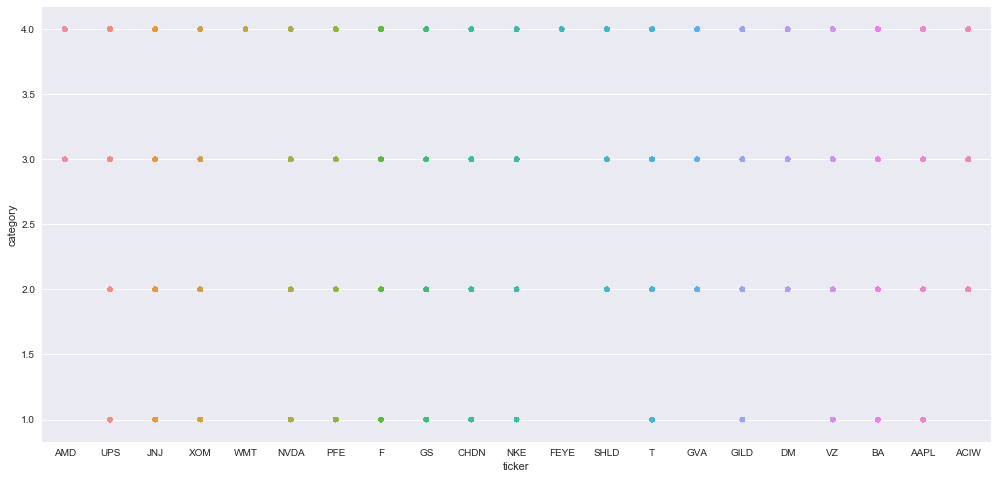

In [123]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.stripplot(y='category', x='ticker', data=combined, ax=ax)

In [124]:
category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
# asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

In [125]:
combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
# combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

,Open,High,Low,Close,Adj Close,Volume,ticker,pct_change,log_return,vol,month_return,month_log_return,category,category_enc,security_enc
Date,,,,,,,,,,,,,,,
2017-07-31,79.82,80.34,79.69,79.989998,79.49,6263200,WMT,0.006376,0.006356,NaN,-0.014994,-0.015623,4,0,4
2017-08-01,80.25,80.73,80,80.500000,79.9968,5726500,WMT,0.000373,0.000373,NaN,NaN,NaN,4,0,4
2017-08-02,80.34,81.11,80.3,80.529999,80.0266,8673000,WMT,0.004222,0.004213,NaN,NaN,NaN,4,0,4
2017-08-03,81.34,81.76,80.67,80.870003,80.3645,9946900,WMT,-0.004823,-0.004834,NaN,NaN,NaN,4,0,4
2017-08-04,81.06,81.4,80.21,80.480003,79.9769,7141800,WMT,0.009940,0.009891,NaN,NaN,NaN,4,0,4
2017-08-07,80.57,81.45,80.54,81.279999,80.7719,5484500,WMT,0.003814,0.003807,NaN,NaN,NaN,4,0,4
2017-08-08,81.17,81.86,80.9,81.589996,81.08,7381400,WMT,0.000245,0.000245,NaN,NaN,NaN,4,0,4
2017-08-09,81.11,81.99,80.9,81.610001,81.61,6606500,WMT,-0.011641,-0.011709,NaN,NaN,NaN,4,0,4
2017-08-10,81.07,81.4,80.55,80.660004,80.66,8045000,WMT,-0.003223,-0.003229,NaN,NaN,NaN,4,0,4


In [126]:
combined.groupby('ticker').mean()[['vol', 'category_enc']].sort_values('vol')

,vol,category_enc
ticker,,
UPS,0.012827,2.443849
XOM,0.013646,2.459293
JNJ,0.013883,2.293555
VZ,0.014507,2.277510
T,0.014661,2.248268
PFE,0.017079,1.880224
BA,0.019578,1.540608
F,0.020539,1.480943
NKE,0.020775,1.323729


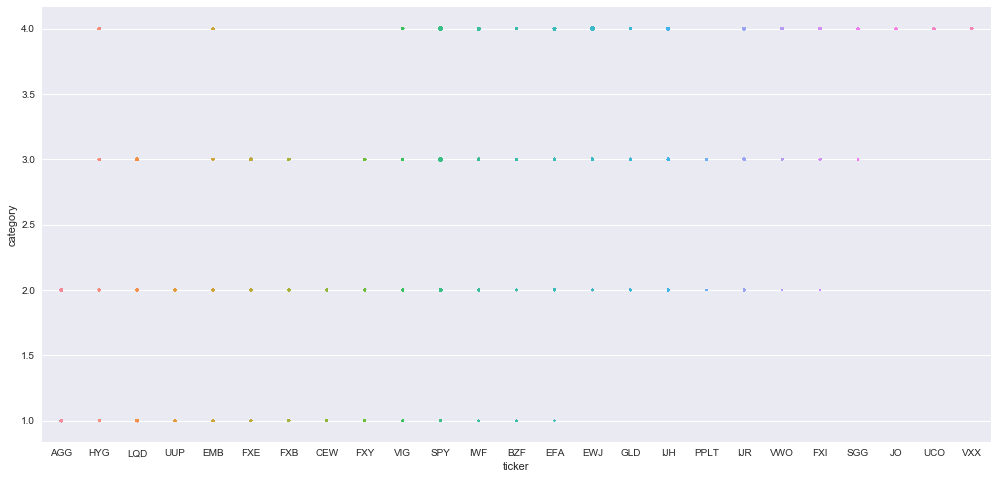

In [94]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.stripplot(x='ticker', y='category', data=combined.sort_values('vol'), size=combined.sort_values('vol')['vol']*1000, ax=ax)
# sns.stripplot(x='ticker', y='vol', data=combined.sort_values('vol'), ax=ax)

# Step 2:
## Build hierarchical regression model

In [128]:
combined = combined.dropna()

In [65]:
combined.groupby('category').mean()

,Close,pct_change,log_return,vol,month_return,month_log_return,corr,beta,market_log_return,alpha,beta_abs,ra_return,ra_month_return,fast,slow,momentum,value,alpha_month,security_enc
category,,,,,,,,,,,,,,,,,,,
0,94.663960,-0.000036,-0.000046,0.004328,-0.000920,-0.001185,0.119799,0.096268,0.000326,-8.854220e-05,0.189047,0.034134,0.747241,94.670468,94.261448,-0.000129,0.001269,-0.002031,19.217952
1,87.519978,0.000242,0.000208,0.007934,0.004816,0.003983,0.639943,0.672836,0.000337,-4.697676e-07,0.714222,0.012807,0.279820,87.466651,79.742950,0.002033,0.112322,-0.000589,21.046543
2,66.070617,0.000267,0.000213,0.010084,0.007342,0.006123,0.630059,0.757906,0.000302,-1.824044e-05,0.773658,0.002429,0.059786,66.019803,60.450381,0.003241,0.114202,0.000517,24.087255
3,65.310044,0.000439,0.000361,0.012152,0.007676,0.005791,0.588289,0.837033,0.000357,7.827948e-05,0.838442,-0.002878,-0.086178,65.246733,58.670191,0.002831,0.129285,0.000848,23.298406
4,61.180365,0.000276,0.000176,0.014133,0.006479,0.004142,0.601755,0.892820,0.000229,-7.140931e-06,0.893522,-0.019117,-0.412842,61.168279,54.419506,0.002363,0.144307,-0.000373,23.342088
5,46.113798,0.000373,0.000232,0.016434,0.010010,0.006806,0.564325,0.928462,0.000289,-7.838580e-05,0.929333,-0.006944,-0.102445,46.069853,42.789989,0.002455,0.137244,-0.000185,24.488210
6,43.408674,0.000408,0.000208,0.019623,0.009802,0.005154,0.522607,0.962057,0.000248,-5.525583e-05,0.963412,-0.006773,-0.183911,43.403204,39.826653,0.001962,0.162515,-0.000286,21.440531
7,33.896179,0.000472,0.000173,0.023901,0.009461,0.002913,0.473681,0.998270,0.000175,-7.350963e-05,1.008627,-0.001547,-0.034721,33.894768,32.704482,0.001385,0.193879,-0.003419,20.988253
8,36.708163,0.000352,-0.000073,0.029762,0.006172,-0.003313,0.456433,0.994105,0.000327,-3.408235e-04,1.128492,-0.001292,-0.029406,36.715863,82.702237,-0.000575,-0.016547,-0.007275,19.294876


In [130]:
groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)
sec_category_map

array([0, 1, 0, 1, 2, 3, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 0, 1, 2, 0, 1, 2, 3, 0,
       1, 2, 0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2])

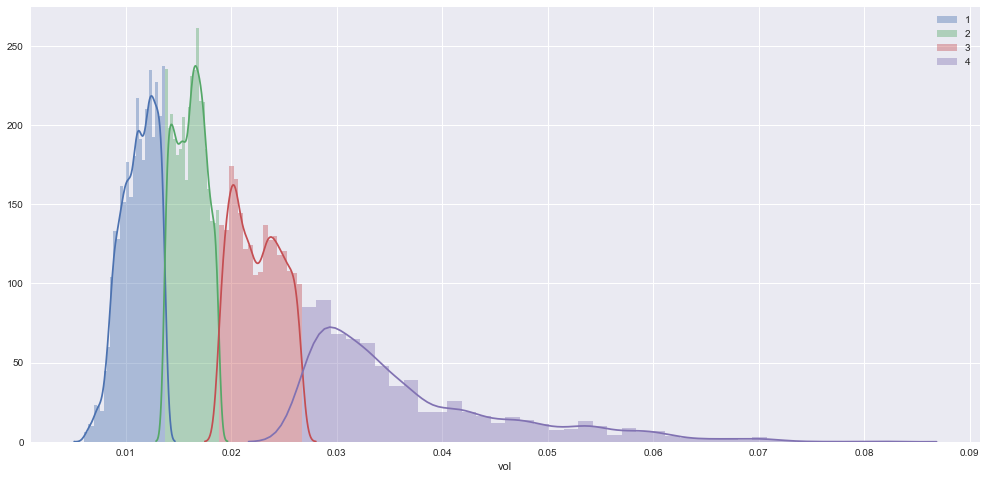

In [177]:
fig, ax = plt.subplots(figsize=(17, 8))
legend = []
for key, grp in combined.groupby('category'):
#     sns.distplot(grp['vol'], ax=ax)
    sns.distplot(grp['vol'], ax=ax)
    legend.append(key)
plt.legend(legend)

In [12]:
for key, grp in combined.groupby('ticker'):
        combined.loc[combined['ticker'] == key, 'alpha_month'] = pd.rolling_sum(grp['alpha'][::-1], window=22,
                                                                                    min_periods=22)[::-1]

/Users/benjaminglickenhaus/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=22,min_periods=22).sum()
  This is separate from the ipykernel package so we can avoid doing imports until


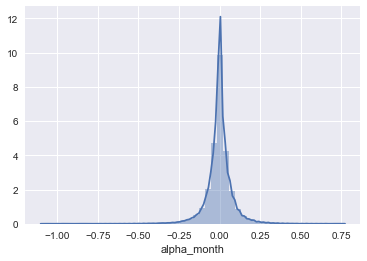

In [14]:
sns.distplot(combined['alpha_month'].dropna())

In [220]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [270]:
try:
    combined = pd.read_pickle('combined.pkl')
except:
    prices, combined = build_prices_dfs()
    pd.to_pickle(combined, 'combined.pkl')

    
for key, grp in combined.groupby('ticker'):
        combined.loc[combined['ticker'] == key, 'alpha_month'] = pd.rolling_sum(grp['alpha'][::-1], window=22,
                                                                                    min_periods=22)[::-1]
combined['category'] = pd.qcut(combined['vol'], 10, labels=range(10))
combined = combined.dropna()
# combined = combined.iloc[np.random.choice(len(combined), 50000), :]

# asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

# combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

groupby = 'category'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)
sec_category_map
# n_assets = len(asset_encodings)
n_categories = len(np.unique(sec_category_map))
n_securities = len(security_encodings)

train, test = train_test_split(combined, test_size=.3)

with pm.Model() as model:
    a_mu_m = pm.Normal('a_mu_m', mu=0, sd=5)
    a_sd_m = pm.Uniform('a_sd_m', 1, 5)
    
#     a_mu_v = pm.Normal('a_mu_v', mu=0, sd=5)
#     a_sd_v = pm.Uniform('a_sd_v', 1, 5)
    
    
    a_mom = pm.Normal('a_mom', mu=a_mu_m, sd=a_sd_m, shape=n_categories)
#     a_val = pm.Normal('a_val', mu=a_mu_v, sd=a_sd_v, shape=n_categories)
    
    a_beta = pm.Normal('a_beta', mu=0, sd=5)
    
    b_mu = pm.Normal('b_mu', mu=0, sd=3)
    b_sd = pm.Uniform('b_sd', 1, 3)
    b_sec = pm.Normal('b_security', mu=b_mu, sd=b_sd, shape=n_categories)
    
    # Forward returns ~ Indicator * slope + intercept
    p = invlogit(train['momentum'].values * a_mom[train['category'].values] +
#              train['value'].values * a_val[train['category'].values] + 
             train['beta_abs'].values * a_beta +
             b_sec[train['category'].values])
#     epsilon = pm.Uniform('epsilon', 1, 5)
#     nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.Bernoulli('likelihood', p=p, observed=np.where(train['month_log_return'].values > 0, 1, 0))
#     likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=train['month_log_return'].values)
#     trace = pm.sample(50, init='advi', n_init=50000, step=pm.NUTS())

/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=22,min_periods=22).sum()


In [271]:
with model:
    trace = pm.sample(500, init='advi', n_init=50000, step=pm.NUTS())

100%|██████████| 1000/1000 [17:23<00:00,  2.42it/s]


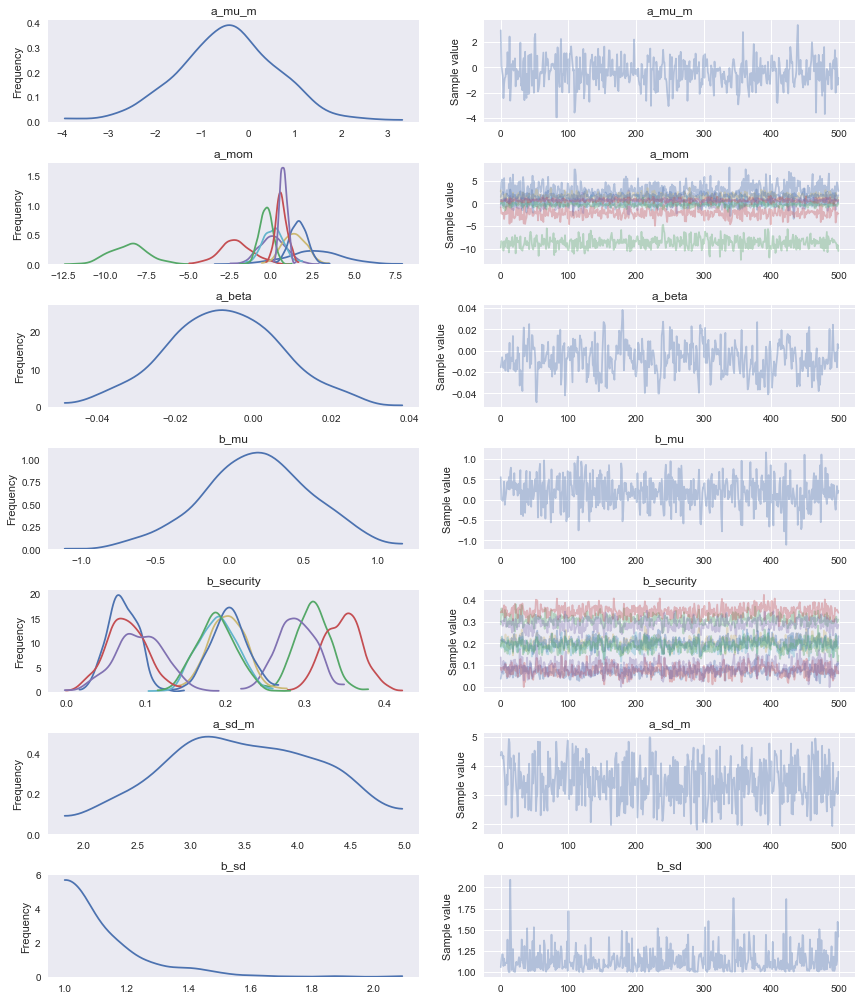

In [272]:
pm.traceplot(trace);

In [255]:
with model:
    approx = pm.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

Average Loss = 74,214: 100%|██████████| 50000/50000 [29:47<00:00, 27.98it/s]
Finished [100%]: Average Loss = 74,214


In [262]:
means = approx.gbij.rmap(approx.mean.eval())
sds = approx.gbij.rmap(approx.std.eval())

In [263]:
from scipy import stats
varnames = means.keys()
dists_y = dict()
dists_x = dict()
dists = dict()
for var in varnames:
    mu_arr = means[var]
    sigma_arr = sds[var]
    dists_y[var] = []
    dists_x[var] = []
    dists[var] = []
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        dists_y[var].append(y)
        dists_x[var].append(x)
        if 'interval' not in var:
            dists[var].append(np.multiply(x, y))

In [264]:
def pred_advi(row):
    a = (row.momentum * dists['a_mom'][row.category] +
#          row.value * dists['a_val'][row.category] + 
         row.beta_abs * dists['a_beta'][0] +
         dists['b_security'][row.category])
    return pd.Series(dict(prediction=np.mean(np.exp(a)/(1+np.exp(a))),
                          uncertainty=np.std(np.exp(a)/(1+np.exp(a)))))
#     return np.mean(a > 0)

In [273]:
def calc_prediction_helper(row):
    a = (row.momentum * trace['a_mom'][:, row.category] +
         row.beta_abs * trace['a_beta'] +
#          row.value * trace['a_val'][:, row.category] +
         trace['b_security'][:, row.category])
    return np.mean(np.exp(a)/(1+np.exp(a)))

In [274]:
# from scipy import stats
# import seaborn as sns
# varnames = means.keys()
# fig, axs = plt.subplots(nrows=len(varnames), figsize=(12, 18))
# for var, ax in zip(varnames, axs):
#     mu_arr = means[var]
#     sigma_arr = sds[var]
#     ax.set_title(var)
#     for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
#         sd3 = (-4*sigma + mu, 4*sigma + mu)
#         x = np.linspace(sd3[0], sd3[1], 300)
#         y = stats.norm(mu, sigma).pdf(x)
# #         ax.plot(x, y)
#         sns.distplot(np.multiply(x, y), ax=ax)
# fig.tight_layout()

In [275]:
test['prediction'] = test.apply(calc_prediction_helper, axis=1)

/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [266]:
test['prediction'] = 0
test['uncertainty'] = 0
test.loc[:, ['prediction', 'uncertainty']] = test.apply(pred_advi, axis=1)

/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [276]:
np.mean(test['prediction'].round(0) == np.where(test['month_log_return'] > 0, 1, 0))

0.54463049498096228

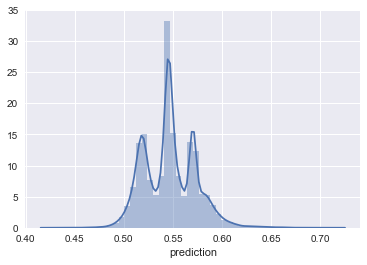

In [277]:
sns.distplot(test['prediction'])

/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


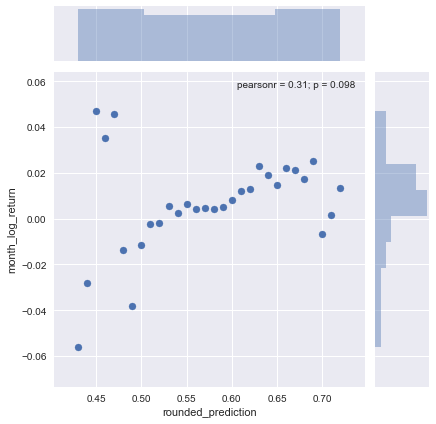

In [278]:
test['rounded_prediction'] = test['prediction'].round(2)
sns.jointplot(test.groupby('rounded_prediction').mean()['month_log_return'].index,
              test.groupby('rounded_prediction').mean()['month_log_return'])

In [279]:
low, high = (.45, .55)#grp['prediction'].quantile([.25, .75])
uncertainty_cutoff = .12
longs = test.loc[(test.prediction >= high), 'month_log_return']
shorts = test.loc[(test.prediction <= low), 'month_log_return']
print('Avg. return on long positions: {}'.format(longs.mean()))
print('Avg. return on short positions: {}\n'.format(shorts.mean()))

Avg. return on long positions: 0.005537968347743452
Avg. return on short positions: 0.039179475686878615



In [ ]:
dists

In [54]:
s = '['
for a in trace['a_mom']:
    s += str(a) + ', '
s = s[:-2]
s += ']'
print(s)

[0.0, 0.0, 0.0332182921445, 0.0354045000097, 0.0395407204594, 0.0922857904276, 0.090407202631, 0.157201693016, 0.125452197142, 0.0943859025785, 0.113102551794, 0.141816530255, 0.111149291722, 0.0621167961445, 0.0535364431138, 0.0248846814445, -0.0302334351136, -0.0349357541535, -0.0575418704746, -0.0611935769644, -0.025159807369, -0.0246242904954, -0.0339441011669, -0.0548254381407, -0.0419675029487, -0.0318377197272, -0.0244916992602, -0.063225152605, -0.0923499974406, -0.0969040988676, -0.112339063082, -0.115888457285, -0.109204035327, -0.0983932056321, -0.111649036828, -0.109701795067, -0.1792984708, -0.180498058572, -0.197717816934, -0.197717816934, -0.248544518711, -0.575698433091, -0.578547860028, -0.56006611755, -0.516075171448, 0.107033758774, 0.0770597755707, 0.0765192182412, 0.0765192182412, 0.145834474759, -0.00735496619901, -0.0357829476989, -0.0531843635567, -0.0531843635567, 0.277361503587, 0.15754005444, 0.0302213012909, 0.0601149619007, 0.0601149619007, -0.0934745946686

In [55]:
s = '['
for a in trace['a_vol']:
    s += str(a) + ', '
s = s[:-2]
s += ']'
print(s)

[0.0, 0.0, -0.0865671107916, -0.0887115685114, -0.04528750228, -0.00100313704139, 0.00953960362198, -0.261122510562, -0.330338126377, -0.350587719009, -0.346961079965, -0.382882988767, -0.441804288082, -0.389340127678, -0.416569042603, -0.501991361493, -0.550107164907, -0.568434362108, -0.562642825319, -0.585270704277, -0.599353776205, -0.597063638002, -0.610879377982, -0.66459613065, -0.666510392502, -0.63438292476, -0.626694365229, -0.568361777197, -0.595823855042, -0.601250745036, -0.226219573824, -0.222896806527, -0.252368911112, -0.322175897641, -0.325585114009, -0.239669743001, -0.241404384223, -0.25197220348, -0.264373587421, -0.264373587421, -0.209839869868, -0.905803635028, -0.919888177022, -0.936008534701, -0.625991984214, 0.893518108451, 0.79983400768, 0.436925161285, 0.436925161285, 0.382252514154, 0.0915284084386, 0.0880654666982, 0.335514269673, 0.335514269673, 0.331518273701, 0.87880696783, 0.640963555805, 0.624185592465, 0.624185592465, 0.189741598777, 0.131763503421, 1

In [219]:
s = '['
for a in np.transpose(trace['b_security']):
    s += '['
    for v in a:
        s += str(v) + ', '
    s = s[:-2] + '], '
s = s[:-2]
s += ']'
print(s)

[[0.00548856588369, 0.0200991865663, 0.0452470053991, 0.0230040370926, 0.00618432228427, 0.0112205086066, 0.00612034264962, 0.0179533899684, 0.00167273718004, 0.0174159080971, 0.00962579235517, 0.00820383735935, 0.00546850582597, -0.00123205373008, -0.00123205373008, 0.0057686719813, 0.0174162303111, 0.0174162303111, -0.00106313898925, 0.010949822637, -0.00861094572295, 0.0221186558201, 0.00230411547556, 0.00230411547556, 0.0234329313967, -0.00583099103411, -0.00941530596289, 0.026084319402, -0.00725466353437, 0.0235099288723, -0.00797958853816, -0.00249097626283, -0.00249097626283, 0.0143058088809, 0.011294104652, 0.00482982976159, 0.0138667034852, 0.0126285288606, 0.00821399728329, 0.00560732261287, 0.0260125522691, 0.00240613848586, 0.00767280049493, 0.00594895235887, 0.00594895235887, 0.013794384762, 0.0135704919991, 0.0154095343352, 0.000384707314094, 0.000384707314094, 0.00897507328738, 0.00366573676141, 0.0186839851406, -0.00623852109971, -0.00623852109971, -0.00506267687024, 0.

In [220]:
s = '['
for a in np.transpose(trace['a_mom']):
    s += '['
    for v in a:
        s += str(v) + ', '
    s = s[:-2] + '], '
s = s[:-2]
s += ']'
print(s)

[[-0.523686323478, -0.331613742371, -0.937671112621, -0.536470864817, -0.260347727508, 0.607497499516, 0.466789296282, -0.407631884597, 0.465854267348, -0.373707498203, 0.0599233145218, 0.22297294848, -0.459865710936, 0.574222992297, 0.574222992297, 0.0330285682952, -0.0104582137492, -0.0104582137492, 0.427173334646, -0.419639296875, 0.233361884599, -0.0965733777735, 0.618660907051, 0.618660907051, -0.215769351579, 0.343499856271, 0.276479371282, -0.0738756927046, 0.414846931944, -0.347475103789, 0.489677782542, 0.550660211875, 0.550660211875, -0.0540118685497, -0.344254824611, -0.0475643707721, 0.377360286724, 0.214267775229, 0.227155805554, 0.247975803368, -0.0563221520031, 0.356480465793, -0.0710955738031, 0.420521985365, 0.420521985365, -0.287937339301, -0.102281948418, 0.246608975432, -0.112123882018, -0.112123882018, 0.328791194645, -0.332783127875, -0.0860744413153, 0.335833684495, 0.335833684495, 0.260605839006, 0.153414316465, -0.0484231863567, -0.223979767425, 0.125223340355,

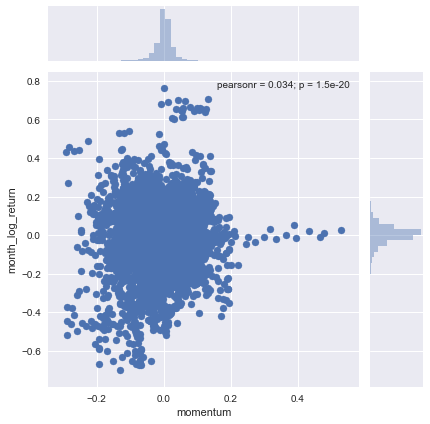

In [451]:
sns.jointplot('momentum', 'month_log_return', data=combined)

In [44]:
test['prediction'].describe()

count    77040.000000
mean         0.470014
std          0.098142
min          0.142000
25%          0.428000
50%          0.480000
75%          0.530000
max          0.736000
Name: prediction, dtype: float64

In [85]:
test['position'] = 0
low, high = test['prediction'].quantile([.25, .75])
test.loc[test.prediction >= high, 'position'] = 1
test.loc[test.prediction <= low, 'position'] = -1
test['bt_return'] = test['log_return'] * test['position']
test['date'] = test.index

/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

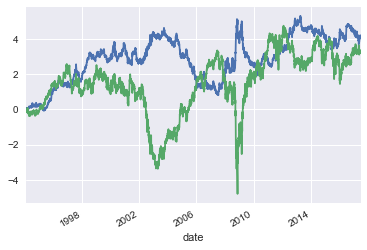

In [86]:
test.groupby('date').sum()['bt_return'].cumsum().plot()
test.groupby('date').sum()['log_return'].cumsum().plot()

In [83]:
test.groupby('position').mean()

,Close,pct_change,log_return,vol,month_return,month_log_return,corr,beta,market_log_return,alpha,...,ra_month_return,fast,slow,momentum,value,alpha_month,security_enc,prediction,rounded_prediction,bt_return
position,,,,,,,,,,,,,,,,,,,,,
-1,74.575694,0.000300,-0.000028,0.023204,0.010086,0.002752,0.624091,1.151831,0.000236,-0.000207,...,0.003853,74.625485,174.946867,-0.000079,0.105004,-0.001777,19.769768,0.369346,0.369398,0.000028
0,52.559320,0.000391,0.000192,0.016935,0.007656,0.003246,0.610444,0.882793,0.000537,-0.000321,...,0.001950,52.535530,48.966474,0.004036,0.101928,-0.002622,21.279047,0.411115,0.410980,0.000000
1,58.681090,0.000280,0.000121,0.014220,0.005873,0.002433,0.316145,0.446182,0.000440,-0.000083,...,0.241725,58.681335,57.902467,0.002683,0.066355,-0.000391,23.918778,0.470201,0.470168,0.000121


In [318]:
# Calculate likelihood of positive forward month returns
a = (.02 * trace['a_security'][:, 10] + trace['b_security'][:, 10])
np.mean(a > 0)

0.98570000000000002

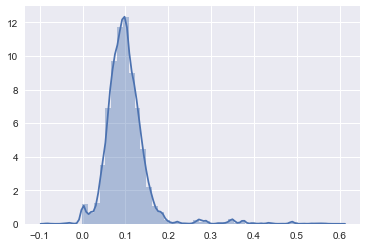

In [319]:
sns.distplot(trace['a_security'][:, 10])

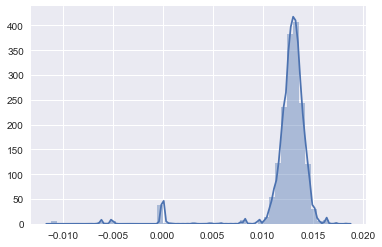

In [320]:
sns.distplot(trace['b_security'][:, 10])

In [327]:
np.mean(combined.loc[combined.security_enc==10, 'month_log_return'])

0.004074313702555441

In [168]:
security_encodings

{'AGG': 4,
 'EFA': 7,
 'EMB': 2,
 'HYG': 3,
 'IJH': 1,
 'IJR': 6,
 'IWF': 5,
 'LQD': 0,
 'SPY': 9,
 'VIG': 8,
 'VWO': 10}

In [326]:
combined.loc[:, ['momentum', 'month_log_return', 'prediction', 'security_enc']].sort_values('month_log_return')

,momentum,month_log_return,prediction,security_enc
Date,,,,
2008-09-25,-0.076662,-0.632523,0.93090,10
2008-09-24,-0.081097,-0.559686,0.91230,10
2008-09-22,-0.084976,-0.496025,0.89490,10
2008-09-25,-0.032976,-0.476216,0.97245,7
2008-09-19,-0.084898,-0.462080,0.89495,10
2008-09-25,-0.030162,-0.459665,0.97435,1
2008-09-23,-0.083429,-0.450323,0.90190,10
2008-09-26,-0.075104,-0.446928,0.93620,10
2008-09-25,-0.012921,-0.425113,0.98040,6


In [227]:
pd.DataFrame([1,2,3,4]).shift(1).rolling(3).mean()

,0
0,NaN
1,NaN
2,NaN
3,2.0
